# Speech Emotion Recognition with K-Nearest Neighbors (KNN)

Welcome to this notebook! In this project, we build a KNN classifier for speech emotion recognition using three CSV files:

- **train_final.csv**: For training the model.
- **val_final.csv**: For hyperparameter tuning and validation.
- **test_final.csv**: For the final evaluation.

The notebook is structured into the following sections:

1. Data Loading & Exploration
2. Data Preprocessing
3. Baseline KNN Model
4. Hyperparameter Tuning
5. Evaluation on Test Data
6. Conclusion and Future Steps

Before we dive into the code, here are some important questions and answers:

## 1. Data Loading & Exploration

In this section, we load the datasets (`train_final.csv`, `val_final.csv`, and `test_final.csv`) into Pandas DataFrames.

In [1]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv('../data/features/train_final.csv')
val_df = pd.read_csv('../data/features/val_final.csv')
test_df = pd.read_csv('../data/features/test_final.csv')

# Combine train_df & val_df into one dataframe as we do not need the validation set for our training
full_train_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)

print("Combined shape:", full_train_df.shape)
print(full_train_df['Emotion'].value_counts())

Combined shape: (52905, 52)
Emotion
Neutral     12500
Happy       10707
Question     6452
Bored        6222
Anger        5050
Sad          4727
Surprise     4126
Fear         1605
Disgust      1516
Name: count, dtype: int64


In [2]:
print(full_train_df.columns)

Index(['Filepath', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC15', 'PC16', 'PC17', 'PC18',
       'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC28',
       'PC29', 'PC30', 'PC31', 'PC32', 'PC35', 'PC36', 'PC37', 'PC38', 'PC40',
       'PC42', 'PC43', 'PC44', 'PC46', 'PC51', 'PC52', 'PC56', 'PC60', 'PC61',
       'PC65', 'PC77', 'PC81', 'PC89', 'PC96', 'PC129', 'Emotion'],
      dtype='object')


## 2. Data Preprocessing

Since KNN is a distance-based algorithm, scaling the features is crucial. In this section, we use `StandardScaler` to standardize our feature values (ie. mean = 0 and unit variance).

Make sure you adjust the feature and target column names as appropriate for your dataset.

In [3]:
from sklearn.preprocessing import StandardScaler

# Define the target column
target_column = 'Emotion'

# Automatically select feature columns by excluding 'Filepath' and the target column
feature_columns = train_df.columns.difference(['Filepath', target_column])

# Create feature matrices (X) and target vectors (y) for training, validation, and testing
X_train = full_train_df[feature_columns]
Y_train = full_train_df[target_column]

X_test = test_df[feature_columns]
Y_test = test_df[target_column]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #Ensuring model learns the correct scaling parameters based solely on the training data
X_test_scaled = scaler.transform(X_test)

## 3. Baseline KNN Model

We begin with a baseline KNN model using default parameters. This will provide a performance benchmark before hyperparameter tuning.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# Baseline KNN model with default settings
baseline_knn = KNeighborsClassifier()
baseline_knn.fit(X_train_scaled, Y_train)

# Predict on the test set
Y_test_pred = baseline_knn.predict(X_test_scaled)

# Compute metrics
accuracy  = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred, average='weighted')
recall    = recall_score(Y_test, Y_test_pred,    average='weighted')
f1        = f1_score(Y_test, Y_test_pred,        average='weighted')

# Print results
print(f"Baseline KNN Test Accuracy : {accuracy:.4f}")
print(f"Baseline KNN Test Precision: {precision:.4f}")
print(f"Baseline KNN Test Recall   : {recall:.4f}")
print(f"Baseline KNN Test F1‑Score : {f1:.4f}\n")

print("Detailed classification report:\n")
print(classification_report(Y_test, Y_test_pred))

Baseline KNN Test Accuracy : 0.6081
Baseline KNN Test Precision: 0.6136
Baseline KNN Test Recall   : 0.6081
Baseline KNN Test F1‑Score : 0.6067

Detailed classification report:

              precision    recall  f1-score   support

       Anger       0.52      0.61      0.56       891
       Bored       0.69      0.83      0.75      1098
     Disgust       0.44      0.44      0.44       273
        Fear       0.46      0.44      0.45       285
       Happy       0.59      0.56      0.58      1885
     Neutral       0.56      0.63      0.59      2203
    Question       0.80      0.68      0.74      1139
         Sad       0.61      0.50      0.55       830
    Surprise       0.67      0.47      0.55       728

    accuracy                           0.61      9332
   macro avg       0.59      0.57      0.58      9332
weighted avg       0.61      0.61      0.61      9332



## 4. Hyperparameter Tuning using GridSearchCV

Next, we optimize our KNN model by tuning hyperparameters. We will use GridSearchCV to search over the following parameter grid:

- **n_neighbors**: Values from 1 to 15
- **weights**: `'uniform'` and `'distance'`
- **metric**: `'euclidean'` and `'manhattan'`

GridSearchCV will perform a 5-fold cross-validation to ensure that our chosen parameters generalize well.

GirdSearchCV works on the training data instead of the validation data to avoid overfitting if the model is repeatedly tuned on a single validation set, and this also prevents "leaking" information from validation data into the model

In [5]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 16)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize the KNN classifier and GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Perform grid search using the training data
grid_search.fit(X_train_scaled, Y_train)

print("Best hyperparameters found:")
print(grid_search.best_params_)

print("\nBest Cross-Validation Score:")
print(grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line

Best hyperparameters found:
{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}

Best Cross-Validation Score:
0.6312257820621869


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.55539174 0.55539174 0.53476987 0.55539174 0.56741329 0.57773367
 0.57913241 0.59289292 0.59138078 0.60117191 0.59527455 0.60748511
 0.60219261 0.60986674 0.60495227 0.61510254 0.60791986 0.61636896
 0.61115207 0.61937435 0.61334467 0.62130233 0.61351479 0.62264436
 0.61542387 0.62273887 0.61799452 0.62667045 0.61600983 0.62419431
        nan 0.56272564        nan 0.56272564        nan 0.58361213
        nan 0.59784519        nan 0.60580285        nan 0.61302334
        nan 0.61631226        nan 0.61939325        nan 0.6220017
        nan 0.62466686        nan 0.62572536        nan 0.62765334
        nan 0.62863623        nan 0.63071543        nan 0.63122578]
  warnings.warn(


## 5. Final Evaluation on Test Data

With the tuned hyperparameters in hand, we now evaluate the best KNN model on the reserved test dataset. This provides an unbiased estimate of our model's performance.

Final KNN Test Accuracy : 0.6466
Final KNN Test Precision: 0.6503
Final KNN Test Recall   : 0.6466
Final KNN Test F1‑Score : 0.6429

Final Classification Report:

              precision    recall  f1-score   support

       Anger       0.66      0.57      0.61       891
       Bored       0.69      0.84      0.76      1098
     Disgust       0.58      0.37      0.45       273
        Fear       0.51      0.41      0.45       285
       Happy       0.68      0.55      0.61      1885
     Neutral       0.57      0.72      0.64      2203
    Question       0.77      0.74      0.76      1139
         Sad       0.62      0.63      0.62       830
    Surprise       0.67      0.55      0.60       728

    accuracy                           0.65      9332
   macro avg       0.64      0.60      0.61      9332
weighted avg       0.65      0.65      0.64      9332



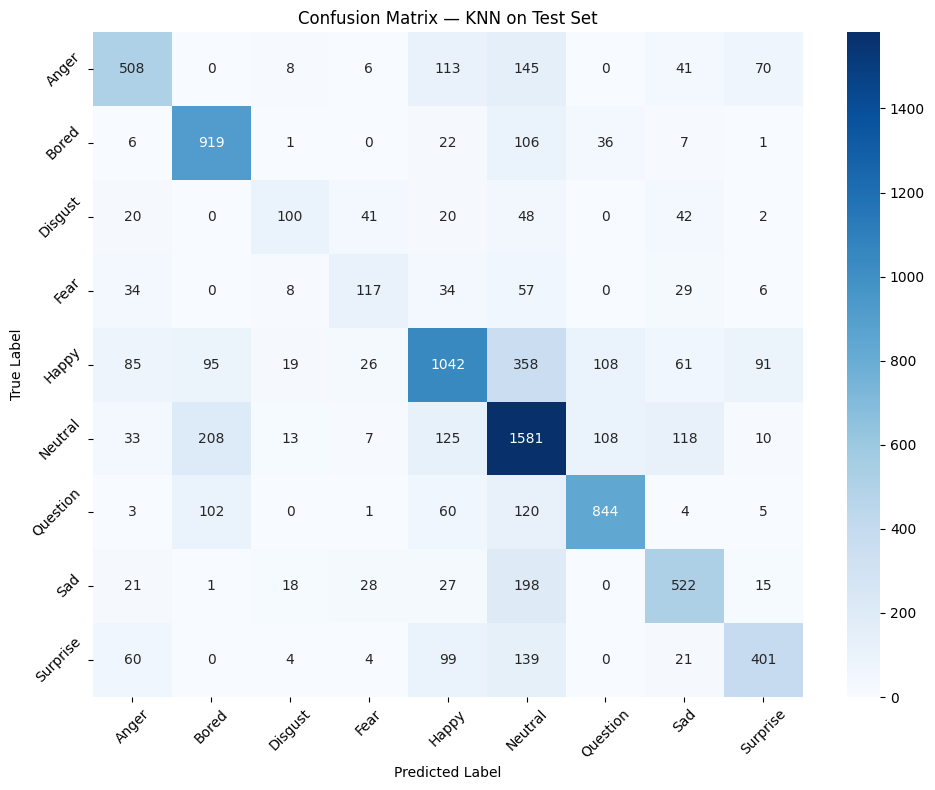

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve the best estimator from the grid search
best_knn = grid_search.best_estimator_ #automatically returns a new KNeighborsClassifer Object preconfigured with the best hyperparameters fund during grid search

# Predict on the test set
Y_test_pred = best_knn.predict(X_test_scaled)

# Compute metrics
accuracy  = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred, average='weighted')
recall    = recall_score(Y_test, Y_test_pred,    average='weighted')
f1        = f1_score(Y_test, Y_test_pred,        average='weighted')

# Print results
print(f"Final KNN Test Accuracy : {accuracy:.4f}")
print(f"Final KNN Test Precision: {precision:.4f}")
print(f"Final KNN Test Recall   : {recall:.4f}")
print(f"Final KNN Test F1‑Score : {f1:.4f}\n")

print("Final Classification Report:\n")
print(classification_report(Y_test, Y_test_pred))

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_pred)

# Get the emotion labels in the correct order
labels = best_knn.classes_  # ['Anger', 'Bored', ..., 'Surprise']

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix — KNN on Test Set')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Conclusion

We have successfully built and tuned a KNN classifier for speech emotion recognition. Here is a summary of what we accomplished:

- **Data Exploration:** Loaded and inspected the datasets, checking for missing values.
- **Preprocessing:** Standardized the features using `StandardScaler`.
- **Baseline Model:** Created a baseline KNN model to set a performance benchmark.
- **Hyperparameter Tuning:** Utilized GridSearchCV to optimize `n_neighbors`, `weights`, and `metric`.
- **Final Evaluation:** Assessed the tuned model on a separate test set for unbiased performance estimation.